<a href="https://colab.research.google.com/github/MarioAvolio/AI-Project/blob/main/assignment%204/2_Rescal_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rescal Implementation

Adapted by Federico Bianchi

[1] [A Three-Way Model for Collective Learning on Multi-Relational Data](https://icml.cc/2011/papers/438_icmlpaper.pdf) (Nickel et al. 2011)

Install the Required Libraries

In [106]:
%%capture
!pip install jax
!pip install tqdm
!pip install optax

In [107]:
import pandas as pd
import numpy as np
from jax import grad
from jax import value_and_grad
from jax import jit
import jax.numpy as jnp
from tqdm import tqdm
import time
import optax
from scipy.spatial.distance import cosine
from jax import random
from jax.nn.initializers import normal

### Load Training Data

In [108]:
data = pd.read_csv("https://raw.githubusercontent.com/ZhenfengLei/KGDatasets/master/Countries/Countries_S1/train.txt", sep="\t", names=["subject", "predicate", "object"])
data

,subject,predicate,object
0,western_africa,locatedin,africa
1,slovakia,neighbor,ukraine
2,slovakia,neighbor,hungary
3,slovakia,neighbor,austria
4,slovakia,neighbor,czechia
...,...,...,...
1106,cambodia,locatedin,south-eastern_asia
1107,panama,locatedin,central_america
1108,anguilla,locatedin,caribbean
1109,cuba,locatedin,caribbean


In [109]:
data_test = pd.read_csv("https://raw.githubusercontent.com/ZhenfengLei/KGDatasets/master/Countries/Countries_S1/test.txt", sep="\t", names=["subject", "predicate", "object"])

In [110]:
entities = list(set(data["subject"].unique().tolist() + data["object"].unique().tolist()))

In [111]:
entities

['tajikistan',
 'eritrea',
 'slovakia',
 'réunion',
 'kyrgyzstan',
 'lebanon',
 'wallis_and_futuna',
 'chile',
 'liberia',
 'bahrain',
 'saint_lucia',
 'eastern_asia',
 'saint_barthélemy',
 'mauritania',
 'liechtenstein',
 'andorra',
 'niue',
 'jamaica',
 'uzbekistan',
 'melanesia',
 'norfolk_island',
 'bermuda',
 'southern_europe',
 'oman',
 'nepal',
 'uganda',
 'saint_kitts_and_nevis',
 'united_arab_emirates',
 'bolivia',
 'egypt',
 'united_states_minor_outlying_islands',
 'guatemala',
 'macedonia',
 'micronesia',
 'bhutan',
 'norway',
 'france',
 'chad',
 'greenland',
 'guadeloupe',
 'curaçao',
 'san_marino',
 'tokelau',
 'lithuania',
 'northern_mariana_islands',
 'dominican_republic',
 'luxembourg',
 'serbia',
 'french_polynesia',
 'japan',
 'central_asia',
 'saudi_arabia',
 'italy',
 'sudan',
 'rwanda',
 'namibia',
 'myanmar',
 'suriname',
 'argentina',
 'fiji',
 'svalbard_and_jan_mayen',
 'equatorial_guinea',
 'uruguay',
 'estonia',
 'czechia',
 'falkland_islands',
 'mozambique',

In [112]:
number_of_entities = len(entities)

In [113]:
number_of_entities

271

## Represent relations as tables

In [114]:
# we initialize the matrices of the relationships

loc_in_matrix = np.zeros((number_of_entities, number_of_entities))
neigh_matrix = np.zeros((number_of_entities, number_of_entities))

Now we add the 1s obtaining a matrix $M$ similar to the following where $m_{i,j} = 1$ for the relation $r$ means that the triple $(e_i, r, e_j)$ exist in the KG.   

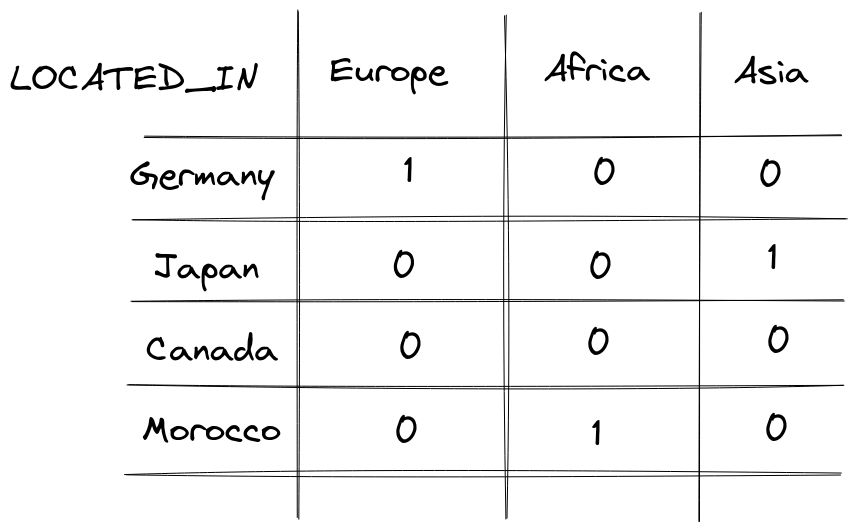

In [115]:
# and we add the 1s.

for index, row in data[data["predicate"] == "locatedin"].iterrows():
    subject_ = row["subject"]
    object_ = row["object"]

    loc_in_matrix[entities.index(subject_)][entities.index(object_)] = 1

for index, row in data[data["predicate"] == "neighbor"].iterrows():
    subject_ = row["subject"]
    object_ = row["object"]

    neigh_matrix[entities.index(subject_)][entities.index(object_)] = 1

In [116]:
loc_in_matrix


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [117]:
# make the matrices jax.numpy objects
loc_in_matrix = jnp.array(loc_in_matrix)
neigh_matrix = jnp.array(neigh_matrix)

RESCAL [1] employs the following rank-$r$ factorization, where each slice $X_k$ is factorized as
$$ Χ_k ≈ AR_kA^T , for k = 1, \ldots , m $$
Here, $A$ is a $n\times r$ ($n$ is the number of entities) matrix that contains the latent-component
representation of the entities in the domain and $R_k$ is an
asymmetric $r\times r$ matrix that models the interactions of the latent components in the $k$-th predicate.

In [118]:
# function to initialize the matrixes
def initialize_parameters(rnd_key, number_of_entities, hidden_size):

    k1, k2 = random.split(rnd_key)

    params = {
        "A" : normal()(k1, (number_of_entities, hidden_size)),
        "R_locatedin" : normal()(k1, (hidden_size,hidden_size)),
        "R_neighbors" :normal()(k1, (hidden_size,hidden_size)),
    }

    return params

In [119]:
# this is a jax-specific thing for reproducibility

rnd_key = random.PRNGKey(1)
rand_key, k1, k2 = random.split(rnd_key, 3)

In [120]:
params = initialize_parameters(rnd_key, number_of_entities, 40)

The factor matrices $A$ and $R_k$ can be computed by solving
the regularized minimization problem
$$\min_{A,R_k} f (A, R_k ) + g(A, R_k )$$
where
$$f (A, R_k ) = \frac{1}{2} \bigg( \sum_k || X_k − AR_k A^T ||^2_F \bigg)$$
and $g$ is a regularization term which we ignore in this tutorial.

## Exercise

Implement the loss function to train RESCAL (ignore the regularization term $g$).

You can use `jnp.linalg.norm(M**2)` to obtain the *squared Frobenius norm* ($||M||^2_F$) of the matrix $M$.

For matrix multiplication you can use `A.dot(B)` while to transpose a matrix $M$ just run `M.T`.

In [121]:
params['A'], params['R_locatedin'], params['R_neighbors']

(Array([[ 0.00866371, -0.01332114, -0.00726191, ...,  0.02261542,
         -0.01224672,  0.00615816],
        [ 0.00212861, -0.00132793, -0.00592347, ...,  0.00664622,
         -0.00050808, -0.00338675],
        [-0.00243504, -0.00429747, -0.00639926, ...,  0.01444154,
          0.01005502, -0.00979163],
        ...,
        [-0.00310661,  0.01415012,  0.00228408, ..., -0.00483812,
         -0.00734852,  0.01352155],
        [ 0.00472718, -0.00504683,  0.00064599, ...,  0.00996262,
          0.00025257,  0.01755651],
        [-0.01155617, -0.0024557 ,  0.00161922, ...,  0.00854622,
         -0.01110045, -0.00748727]], dtype=float32),
 Array([[ 0.00826546,  0.00049275,  0.01752382, ...,  0.00263281,
         -0.00840951,  0.00419681],
        [ 0.0093708 ,  0.00035016,  0.00704468, ..., -0.00513814,
          0.00228167, -0.00061239],
        [-0.01852107, -0.00074308,  0.00180524, ...,  0.01382972,
         -0.00601451, -0.00070728],
        ...,
        [-0.00324565,  0.003786  , -0.0

In [122]:
jnp.linalg.norm((neigh_matrix - params['A'].dot(params['R_neighbors']).dot(params['A'].T))**2)

Array(25.455826, dtype=float32)

In [123]:
def loss_function(params, located_in_matrix, neighbors_matrix):

  loss_neighbor = jnp.linalg.norm((neigh_matrix - params['A'].dot(params['R_neighbors']).dot(params['A'].T))**2)


  loss_locin = jnp.linalg.norm((loc_in_matrix - params['A'].dot(params['R_locatedin']).dot(params['A'].T))**2)


  loss = (loss_neighbor + loss_locin) / 2


  return loss

### Solution

In [124]:
def loss_function(params, located_in_matrix, neighbors_matrix):

  loss_located_in = jnp.linalg.norm((
      located_in_matrix - params['A'].dot(params['R_locatedin']).dot(params['A'].T)
    )**2)

  loss_neighbors = jnp.linalg.norm((
      neighbors_matrix - params['A'].dot(params['R_neighbors']).dot(params['A'].T)
    )**2)

  loss = 0.5 * (loss_located_in + loss_neighbors)

  return loss


In [125]:
def loss_function(params, located_in_matrix, neighbors_matrix):

    err1 = jnp.linalg.norm((
        located_in_matrix \
          - params["A"].dot(params["R_locatedin"].dot(params["A"].T)))**2)

    err2 = jnp.linalg.norm((
        neighbors_matrix \
          - params["A"].dot(params["R_neighbors"].dot(params["A"].T)))**2)

    return err1 + err2


Testing if we can get the gradient of this

In [126]:
params = initialize_parameters(rnd_key, number_of_entities, 40)
l, _ = value_and_grad(loss_function)(params, loc_in_matrix, neigh_matrix)
l

Array(46.95002, dtype=float32)

### Optimization

We can either use SGD or Adam. SGD can be written manually, for Adam we rely on the optax libary. In the rest of the colab we will use the optax impelementation, but I will also add the SGD version to give you the idea of what it takes to implement it.

In [127]:
# SGD

@jit
def update(params, located_in_matrix, neigh_matrix):
    lr = 0.01

    loss_value, grads = value_and_grad(loss_function)(params, located_in_matrix, neigh_matrix)

    new_params = {}

    new_params["A"] = params["A"] - lr*grads["A"]
    new_params["R_neighbors"] = params["R_neighbors"] - lr*grads["R_neighbors"]
    new_params["R_locatedin"] = params["R_locatedin"] - lr*grads["R_locatedin"]

    return loss_value, new_params


In [128]:
# OPTAX Version

@jit
def optimize(params, opt_state, x, y):
    loss_value, grads = value_and_grad(loss_function)(params, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss_value, opt_state, params

### Training

In [129]:
epochs = 100
embedding_size = 80


params = initialize_parameters(rnd_key, number_of_entities, embedding_size)
opt_init, opt_update = optax.adam(0.001)
opt_state = opt_init(params)
pbar = tqdm(total=epochs, position=0)

for _ in range(0, epochs):
    loss_value, opt_state, params = optimize(params, opt_state, loc_in_matrix, neigh_matrix) # optimization

    pbar.update(1)
    pbar.set_description(f"{loss_value}")


17.877899169921875: 100%|██████████| 100/100 [00:03<00:00, 49.72it/s]

# Playing with some examples

In [130]:
# these are the ids of the countries

ukr_idx = entities.index("ukraine")
slo_idx = entities.index("slovakia")
zam_idx = entities.index("zambia")

In [131]:
entities[ukr_idx]

'ukraine'

In [132]:
# we can get the embedding of each country by accessing the corresponding row

ukr = params["A"][ukr_idx]
slo = params["A"][slo_idx]
zambia = params["A"][zam_idx]

In [133]:
ukr.shape

(80,)

In [134]:
1 - cosine(ukr, zambia), 1 - cosine(ukr, slo)

(0.15628907084465027, 0.7345280647277832)

In [135]:
reconstructed_located_in = params["A"].dot(params["R_locatedin"].dot(params["A"].T)) # we reconstruct the original located_in matrix

reconstructed_located_in = np.array(reconstructed_located_in) # we cast to numpy array

In [136]:
canada_idx = entities.index("canada") # index of canada
canada_row = reconstructed_located_in[canada_idx] # we get the row corresponding to canada in the embedding

top_prediction = np.argmax(canada_row)

print(entities[top_prediction], canada_row[top_prediction])

americas 0.41254035


In [137]:
def get_top_k_predictions(entity, relation_matrix, top_k):
  ent_idx = entities.index(entity)
  ent_row = relation_matrix[ent_idx]

  top_predictions = np.argsort(ent_row)[::-1][:top_k]

  return [(entities[k], ent_row[k]) for k in top_predictions]

In [138]:
get_top_k_predictions('canada', reconstructed_located_in, 5)

[('americas', 0.41254035),
 ('northern_america', 0.3778671),
 ('central_america', 0.34169424),
 ('western_africa', 0.30609858),
 ('africa', 0.29037565)]

In [139]:
get_top_k_predictions('italy', reconstructed_located_in, 5)

[('europe', 0.6993548),
 ('southern_europe', 0.5054271),
 ('western_europe', 0.46850753),
 ('northern_europe', 0.41749784),
 ('eastern_europe', 0.3526856)]

In [140]:
reconstructed_neighbors = params["A"].dot(params["R_neighbors"].dot(params["A"].T)) # we reconstruct the original located_in matrix

reconstructed_neighbors = np.array(reconstructed_neighbors) # we cast to numpy array

In [141]:
get_top_k_predictions('italy', reconstructed_neighbors, 5)

[('austria', 0.50139177),
 ('italy', 0.49247503),
 ('germany', 0.4902241),
 ('switzerland', 0.46319684),
 ('france', 0.45894837)]

In [142]:
get_top_k_predictions('canada', reconstructed_neighbors, 5)

[('united_states', 0.31993753),
 ('guatemala', 0.30116734),
 ('mexico', 0.3004032),
 ('belize', 0.27691823),
 ('honduras', 0.27005517)]

# Evaluation

In [143]:
countries_test_pd_locatedin = data_test.query('predicate == "locatedin"')
countries_test_pd_locatedin

,subject,predicate,object
0,zambia,locatedin,africa
1,morocco,locatedin,africa
2,san_marino,locatedin,europe
3,canada,locatedin,americas
4,uganda,locatedin,africa
5,belgium,locatedin,europe
6,syria,locatedin,asia
7,mali,locatedin,africa
8,russia,locatedin,europe
9,israel,locatedin,asia


In [144]:
def compute_hits_10(x, reconstructed_located_in, z):
  '''
    Hits@10: it measures the fraction of predictions where the “true” tail entity is in the top 10 entities with the highest score
  '''

  top_k = get_top_k_predictions(x, reconstructed_located_in, 10)
  top_k = [t[0] for t in top_k]
  if z in top_k:
    return 1

  return 0


def compute_mean_rank(x, reconstructed_located_in, z):
  '''
    Mean Rank: it measures the average rank of predictions; if the correct entity’s score
    is the third highest, then the rank is 3 (MR is highly dependent on the number of total
    entities).
  '''

  top_k = get_top_k_predictions(x, reconstructed_located_in, countries_test_pd_locatedin.shape[0])
  top_k = [t[0] for t in top_k]
  return top_k.index(z) + 1




In [145]:
tot_hits = 0
tot_mean_rank = 0
tot_mean_reciprocal_rank = 0
for x,y,z in countries_test_pd_locatedin[["subject", "predicate", "object"]].values:
  tot_hits += compute_hits_10(x, reconstructed_located_in, z)
  tmp = compute_mean_rank(x, reconstructed_located_in, z)
  tot_mean_rank += tmp
  tot_mean_reciprocal_rank += 1/tmp # Mean Reciprocal Rank: it measures the average of the reciprocal ranks (it is bounded between 0 and 1)

# tot_hits
tot_hits/countries_test_pd_locatedin.shape[0], tot_mean_rank/countries_test_pd_locatedin.shape[0], tot_mean_reciprocal_rank/countries_test_pd_locatedin.shape[0]



(1.0, 1.4583333333333333, 0.7708333333333334)

## Visualize

In [146]:
entity_embeddings = params["A"]
entity_embeddings.shape

(271, 80)

In [147]:
params

{'A': Array([[ 0.04709854, -0.03001086,  0.07380712, ...,  0.07188105,
          0.1091206 , -0.04612672],
        [ 0.08904698,  0.08388144,  0.08373504, ..., -0.02320147,
         -0.07893004, -0.0774329 ],
        [ 0.03613332, -0.08359732, -0.03422247, ...,  0.05265324,
          0.08727772, -0.03559837],
        ...,
        [ 0.03738856, -0.05942935, -0.0953012 , ...,  0.05453122,
         -0.05761743, -0.04740874],
        [ 0.04471456, -0.04868362,  0.05542367, ..., -0.07354914,
         -0.07512479,  0.02537071],
        [ 0.12070102, -0.06078396,  0.05176467, ..., -0.04399732,
         -0.03407533,  0.03964461]], dtype=float32),
 'R_locatedin': Array([[-0.06582534, -0.03617536, -0.07317673, ...,  0.03339631,
         -0.07947865,  0.07128205],
        [-0.12208866,  0.0678797 ,  0.06793305, ...,  0.00284255,
          0.06826153,  0.07450921],
        [-0.06133189,  0.08007437,  0.07363804, ...,  0.11250999,
          0.02898993,  0.04706849],
        ...,
        [-0.1002933

In [148]:
params.pop("A", None)

Array([[ 0.04709854, -0.03001086,  0.07380712, ...,  0.07188105,
         0.1091206 , -0.04612672],
       [ 0.08904698,  0.08388144,  0.08373504, ..., -0.02320147,
        -0.07893004, -0.0774329 ],
       [ 0.03613332, -0.08359732, -0.03422247, ...,  0.05265324,
         0.08727772, -0.03559837],
       ...,
       [ 0.03738856, -0.05942935, -0.0953012 , ...,  0.05453122,
        -0.05761743, -0.04740874],
       [ 0.04471456, -0.04868362,  0.05542367, ..., -0.07354914,
        -0.07512479,  0.02537071],
       [ 0.12070102, -0.06078396,  0.05176467, ..., -0.04399732,
        -0.03407533,  0.03964461]], dtype=float32)

In [149]:
relation_embeddings = np.dstack(params.values()).reshape(2,80,80)
relation_embeddings.shape

<ipython-input-149-0a68ad482c69>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  relation_embeddings = np.dstack(params.values()).reshape(2,80,80)


(2, 80, 80)

In [150]:
from operator import sub
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def quick_plot(labels, embedding, colors = None, plot = True):
  """
  we ignore the words we are not interested to reduce the time to compute
  the 2D embeddings, but this is an approximation.
  """

  if not colors:
    colors = ['b' for _ in labels]

  X = embedding
  pca = PCA(n_components=2)

  two_d_emb = pca.fit_transform(X)

  plt.scatter(two_d_emb[:, 0], two_d_emb[:, 1], c = colors)

  for index, label in enumerate(labels):
    # annotate
    plt.annotate(label, xy=(two_d_emb[index, 0], two_d_emb[index, 1]), )

  if plot:
    plt.gcf().set_size_inches(20, 10)
    plt.show()

  return plt, pca

In [151]:
continents = set(data.query('predicate == "locatedin"')['object'].unique())

In [152]:
def get_color(x):
  if x in continents:
    return 'red'
  else:
    return 'blue'

colors = [get_color(ent) for ent in entities]

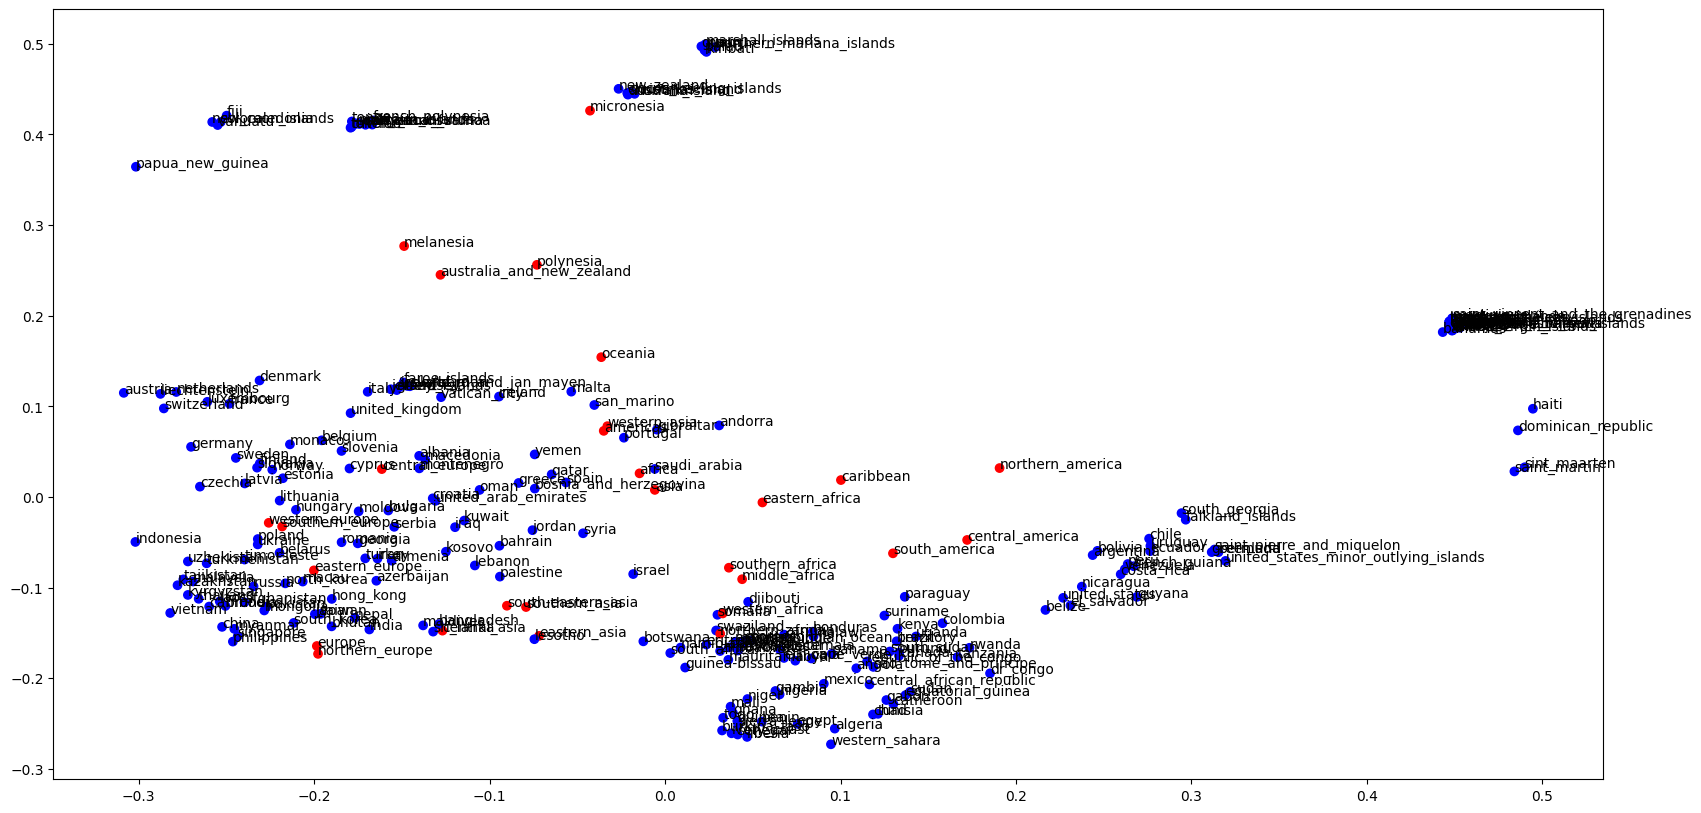

(<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>,
 PCA(n_components=2))

In [153]:
quick_plot(entities, entity_embeddings, colors=colors)